
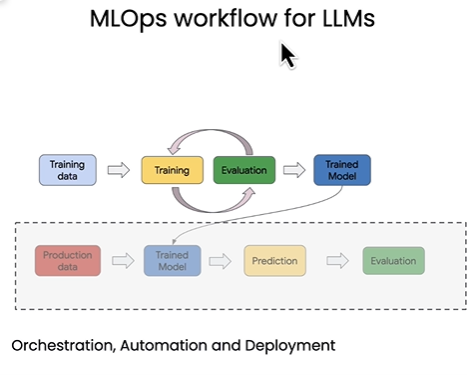

## Automation Pipeline
- Orchestration: What steps to run and in what order (sequence of steps)
- Automation: Automate the workflow (sequence of steps)
- Deployment: Deploy the workflow (sequence of steps)

In [7]:
from kfp import dsl # Domain Specific Language - set of instructions (vocabulary/syntax) for designing pipelines
from kfp import compiler # Create the YAML from the pipeline
from google.cloud.aiplatform import PipelineJob # Execute the pipeline

In [ ]:
# Simple example of a pipeline - Hello World Pipeline

# Define one component of the workflow - Runs into a container
@dsl.component
def say_hello(name: str) -> str:
    hello_text = f'Hello {name}!'
    return hello_text

### Simple example: component 2
@dsl.component
def how_are_you(hello_text: str) -> str:
    how_are_you = f"{hello_text}. How are you?"
    return how_are_you

@dsl.pipeline
def hello_pipeline(recipient: str) -> str:
    hello_task = say_hello(name=recipient)
    
    # notice .output
    how_task = how_are_you(hello_text=hello_task.output)
    
    # notice .output
    return how_task.output

pipeline_output = hello_pipeline(recipient="Erwin")
print(pipeline_output) 

compiler.Compiler().compile(hello_pipeline, 'pipeline.yaml')

pipeline_arguments = {
    "recipient": "World!",
}

job = PipelineJob(
        ### path of the yaml file to execute
        template_path="pipeline.yaml",
        ### name of the pipeline
        display_name=f"deep_learning_ai_pipeline",
        ### pipeline arguments (inputs)
        ### {"recipient": "World!"} for this example
        parameter_values=pipeline_arguments,
        ### region of execution
        location="us-central1",
        ### root is where temporary files are being 
        ### stored by the execution engine
        pipeline_root="./",
)

### submit for execution
job.submit()

### check to see the status of the job
job.state

### Reusing a pipeline
#### Automation and Orchestration of a Supervised Tuning Pipeline.

- Reuse an existing Kubeflow Pipeline for Parameter-Efficient Fine-Tuning (PEFT) for a foundation model from Google, called [PaLM 2](https://ai.google/discover/palm2/). 
- Advantage of reusing a pipleline means you do not have to build it from scratch, you can only specify some of the parameters.

In [4]:
TRAINING_DATA_URI = "./data/tune_data_stack_overflow_python_qa-09-19-01-2024.jsonl"
EVALUATION_DATA_URI = "./data/tune_eval_data_stack_overflow_python_qa-09-19-01-2024.jsonl"

In [12]:
### path to the pipeline file to reuse
template_path = 'https://us-kfp.pkg.dev/ml-pipeline/\
large-language-model-pipelines/tune-large-model/v2.0.0'

# keep tracking of the model
import datetime
date = datetime.datetime.now().strftime("%H-%d-%m-%Y")
MODEL_NAME = f"deep-learning-ai-model-{date}"


### Parameters
 - TRAINING_STEPS: Number of training steps to use when tuning the model. For extractive QA you can set it from 100-500.
- EVALUATION_INTERVAL: The interval determines how frequently a trained model is evaluated against the created evaluation set to assess its performance and identify issues. Default will be 20, which means after every 20 training steps, the model is evaluated on the evaluation dataset.

In [9]:
TRAINING_STEPS = 200
EVALUATION_INTERVAL = 20

In [13]:
from utils import authenticate
credentials, PROJECT_ID = authenticate() 
REGION = "us-central1"

# Defining the arguments
pipeline_arguments = {
    "model_display_name": MODEL_NAME,
    "location": REGION,
    "large_model_reference": "text-bison@001",
    "project": PROJECT_ID,
    "train_steps": TRAINING_STEPS,
    "dataset_uri": TRAINING_DATA_URI,
    "evaluation_interval": EVALUATION_INTERVAL,
    "evaluation_data_uri": EVALUATION_DATA_URI,
}

In [ ]:
pipeline_root = "./"

job = PipelineJob(
        ### path of the yaml file to execute
        template_path=template_path,
        ### name of the pipeline
        display_name=f"deep_learning_ai_pipeline-{date}",
        ### pipeline arguments (inputs)
        parameter_values=pipeline_arguments,
        ### region of execution
        location=REGION,
        ### root is where temporary files are being 
        ### stored by the execution engine
        pipeline_root=pipeline_root,
        ### enable_caching=True will save the outputs 
        ### of components for re-use, and will only re-run those
        ### components for which the code or data has changed.
        enable_caching=True,
)

### submit for execution
job.submit()

### check to see the status of the job
job.state

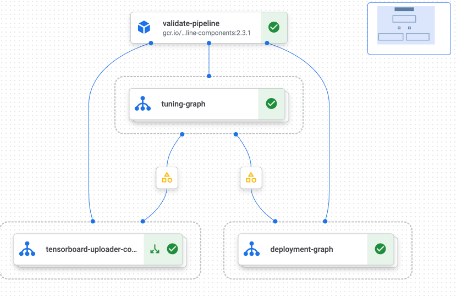